Here , I am importing SparkSession from pyspark.sql to use sparksession to create a spark application that allows us to process data in distributed enviornments.

pyspark.sql - provides functionality to work with structured data using PySpark
Sparksession is the entry point to programming with Apache spark and SQL queries

In [1]:
from pyspark.sql import SparkSession

In the below cell , I am starting a SparkSession and naming out application to Business Analysis in Az.

In [2]:
spark = SparkSession.builder \
    .appName("User Analysis in Arizona") \
    .getOrCreate()

24/11/24 16:53:20 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/11/24 16:53:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 16:53:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Here I am loading all the datasets

In [3]:
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")

24/11/24 16:53:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Filtering out business dataset only to focus on AZ state as our main interest.

In [4]:
AZ_business_df = business_df.filter(business_df["state"] == "AZ")
AZ_business_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|5255 E Broadway Blvd|{null, null, null...|tUFrWirKiKi_TAnsV...|Department Stores...|Tucson|{8:0-23:0, 8:0-22...|      0| 32.223236| -110.880452|              Target|      85711|          22|  3.5|   AZ|
|     625 N Stone Ave|{null, null, null...|rBmpy_Y1UbBx8ggHl...|Automotive, Auto ...|Tucson|{8:0-17:0, 0:0-0:...|      1|32.2298719|-110.9723419|Arizona Truck Out...|      85705|      

Converting json format to parquet for easy retrival of data

In [5]:
AZ_business_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/AZ_business.parquet")
review_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/review.parquet")
tip_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/tip.parquet")
user_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/user.parquet")
checkin_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/checkin.parquet")

Code snippet to see which business categories are in AZ state

In [6]:
categories_AZ_business = AZ_business_df.select("categories").distinct()
categories_AZ_business.show(categories_AZ_business.count(), truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                                                                                                                                                                                                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

I want to choose Mexican restaurants as my category to do analysis on for this Project Milestone 1.

In [7]:
#filtering buinesses that are Mexican and also Restaurants
mexican_restaurants = AZ_business_df.filter(
    (AZ_business_df.categories.like("%Mexican%")) & (AZ_business_df.categories.like("%Restaurants%"))
)

mexican_restaurants_count = mexican_restaurants.count()
print("Number of mexican restaurants in AZ:" , mexican_restaurants_count)


Number of mexican restaurants in AZ: 548


Making sure the datasets has the values that are belongs to the mexican restaurant category only by filtering checkin , tip, review datasets on business_id of the mexican restaurants data

In [8]:
final_checkin_df = checkin_df.join(mexican_restaurants, on="business_id", how="inner")
final_review_df = review_df.join(mexican_restaurants, on="business_id", how="inner")
final_tip_df = tip_df.join(mexican_restaurants, on="business_id", how="inner")


Now filtering users who has user id in our filtered review dataset

In [10]:
final_user_df = user_df.join(final_review_df.select("user_id").distinct(), on="user_id", how="inner")


## Query 1 (Simple)
### List out the users who visited mexican restaurants and had reviewed the most on Yelp?

Datasets used: user_df

In [11]:
final_user_df.createOrReplaceTempView("filtered_users")

top_reviewed_users = spark.sql("""
SELECT user_id, name, review_count
FROM filtered_users
ORDER BY review_count DESC
LIMIT 10
""")

top_reviewed_users.show(truncate = False)

+----------------------+--------+------------+
|user_id               |name    |review_count|
+----------------------+--------+------------+
|hWDybu_KvYLSdEFzGrniTw|Bruce   |16567       |
|Eypq5gLLjCapBVVnMw_MyA|Misha   |5163        |
|cMEtAiW60I5wE_vLfTxoJQ|Jennifer|4190        |
|whINg-cC-FiAv_ATDGMDTg|PatrickJ|3775        |
|3xBFFH866WoySDG7uuwBSQ|Tom     |3204        |
|-G7Zkl1wIWBBmD0KRy_sCw|Gerald  |3131        |
|3XzhO2aJdvVtYhKOCJsPrg|Charley |3012        |
|ZYZNcugF3xUEGyLOVGiZ0Q|Carol   |2960        |
|PLOYtrCMUFPHQe2IbYAd5g|Joanna  |2956        |
|IyIsFkVY48JWa01inv-7zA|Rob     |2904        |
+----------------------+--------+------------+



## Query 2 (Complex)
### List the users who visited mexican restaurants and left the most tips

Datasets used: user_df , tip_df, business_df

In [12]:
final_user_df.createOrReplaceTempView("filtered_users")
final_tip_df.createOrReplaceTempView("filtered_tips")
mexican_restaurants.createOrReplaceTempView("mexican_restaurants")

top_tipping_users = spark.sql("""
SELECT 
    u.user_id, 
    u.name, 
    COUNT(t.text) AS tip_count
FROM 
    filtered_users u
JOIN 
    filtered_tips t 
ON 
    u.user_id = t.user_id
JOIN 
    mexican_restaurants m 
ON 
    t.business_id = m.business_id
GROUP BY 
    u.user_id, u.name
ORDER BY 
    tip_count DESC
LIMIT 10
""")

top_tipping_users.show(truncate = False)


+----------------------+--------+---------+
|user_id               |name    |tip_count|
+----------------------+--------+---------+
|xWmYN57XXZbg0LOK8WbbFQ|John    |195      |
|juigu8XxwzLAeikeBzULbg|Dawn    |61       |
|6ObFF8-uKnOAlXuSH4TlyQ|Isabella|54       |
|pV-zk27LoaY3sQiSr9kImg|Dr Tim L|44       |
|h4R6fncPMTOOjlAg8gOhnQ|Jerry   |31       |
|oAvO0BOHOagOI7WVGXlWSA|Ray     |27       |
|W9kZgeqUS24aVjpAHNGTvg|Shana   |26       |
|LPQBCLsfVVjZh_TbqRqGWA|Lawrence|26       |
|aHl-3UItyhhS9P40Nr9EaA|Monica  |23       |
|O1_mLC0sVAS2RqsfPZTiXg|Shirley |22       |
+----------------------+--------+---------+



### Query 3 (Simple)
## List the most popular users who has visited mexican restaurants?

Dataset used: user_df

In [13]:
top_fans_users = spark.sql("""
SELECT user_id, name, fans
FROM filtered_users
ORDER BY fans DESC
LIMIT 10
""")

top_fans_users.show(truncate=False)


+----------------------+----------+----+
|user_id               |name      |fans|
+----------------------+----------+----+
|wEE-YMx5pmSuagLtNxMPKA|Stephanie |1761|
|zFYs8gSUYDvXkb6O7YkRkw|Joyce     |1662|
|JADdo9NEeO5Az9aOYbyvZA|Manda Bear|1648|
|IDVFG1pNSHIHoVuoLuZpcQ|Andy      |1377|
|nxWrhF_hyX0wwjrEkQX8uQ|Ryan      |1260|
|mvK1pv-x0Z5rP4Hz9cWBWw|Betty     |1165|
|jt49xjEjQisu6wTTGn6B3A|Annette   |1091|
|f1MFQxTZAWJnRQdrouLg_A|Matt      |1082|
|chhv5egoLSXHs4my1HCJeg|Margaret  |1054|
|NrSURtBigpxbdfL4nGB-Jg|Missy     |1003|
+----------------------+----------+----+



## Query 4
### List out the total tips by the popular users?

Datasets used: ttip_df, user_df, business_df.

In [14]:
final_user_df.createOrReplaceTempView("filtered_users")
final_tip_df.createOrReplaceTempView("filtered_tips")
mexican_restaurants.createOrReplaceTempView("mexican_restaurants")

popular_users_mexican_reviews = spark.sql("""
SELECT 
    u.user_id, 
    u.name, 
    u.fans, 
    COUNT(t.text) AS total_tips
FROM 
    filtered_users u
JOIN 
    filtered_tips t
ON 
    u.user_id = t.user_id
JOIN 
    mexican_restaurants m 
ON 
    t.business_id = m.business_id
GROUP BY 
    u.user_id, u.name, u.fans
ORDER BY 
    u.fans DESC
LIMIT 10
""")

popular_users_mexican_reviews.show(truncate=False)


+----------------------+---------+----+----------+
|user_id               |name     |fans|total_tips|
+----------------------+---------+----+----------+
|wEE-YMx5pmSuagLtNxMPKA|Stephanie|1761|1         |
|f1MFQxTZAWJnRQdrouLg_A|Matt     |1082|1         |
|NrSURtBigpxbdfL4nGB-Jg|Missy    |1003|4         |
|c8FOqDRhtL7q_YsQio6bog|Kevin    |843 |1         |
|6ObFF8-uKnOAlXuSH4TlyQ|Isabella |824 |54        |
|A0j21z2Q1HGic7jW6e9h7A|Georgie  |681 |2         |
|DK57YibC5ShBmqQl97CKog|Karen    |542 |4         |
|gZHCbDOkHdHIk2d02FN3kw|Morgan   |442 |1         |
|5BpJEC8YVi80ecWT5CtlfQ|Jenny    |427 |1         |
|UqkrP5O2ToeXRcYbp7okIA|Cassandra|349 |1         |
+----------------------+---------+----+----------+



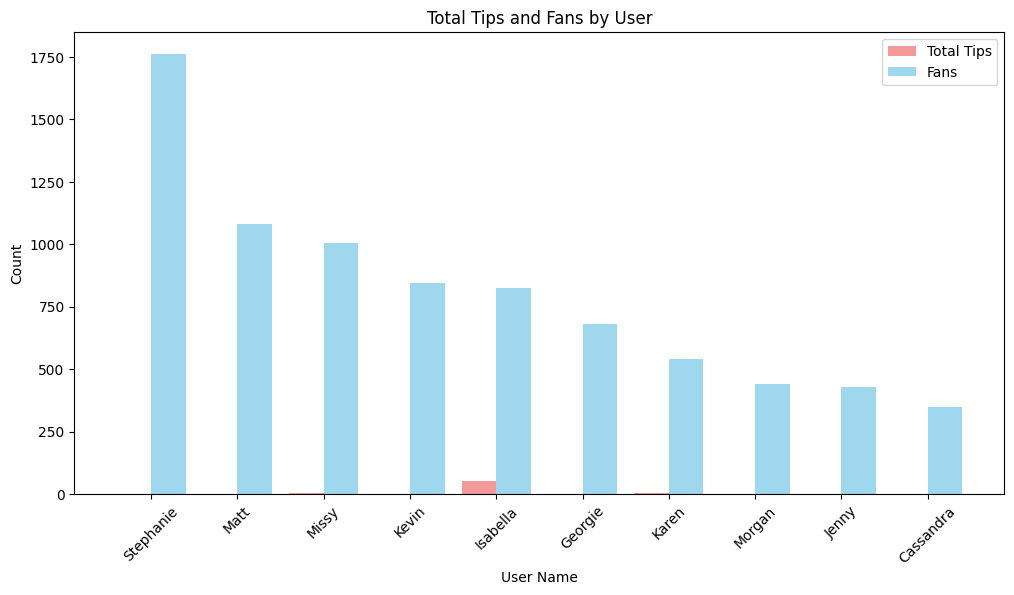

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "name": ["Stephanie", "Matt", "Missy", "Kevin", "Isabella", "Georgie", "Karen", "Morgan", "Jenny", "Cassandra"],
    "total_tips": [1, 1, 4, 1, 54, 2, 4, 1, 1, 1],
    "fans": [1761, 1082, 1003, 843, 824, 681, 542, 442, 427, 349]
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

x = range(len(df["name"]))
width = 0.4  

plt.bar(x, df["total_tips"], width=width, label="Total Tips", color="lightcoral", alpha=0.8)
plt.bar([p + width for p in x], df["fans"], width=width, label="Fans", color="skyblue", alpha=0.8)

plt.xticks([p + width / 2 for p in x], df["name"], rotation=45)

plt.xlabel("User Name")
plt.ylabel("Count")
plt.title("Total Tips and Fans by User")

plt.legend()

plt.show()


### Query 5
## Find the most popular and oldest users who visited mexican restaurants?

Dataset used: user_df

In [16]:
old_popular_user = spark.sql("""
SELECT 
    user_id, 
    name, 
    fans, 
    YEAR(yelping_since) AS yelping_since_year
FROM 
    filtered_users
ORDER BY 
    fans DESC
LIMIT 10
""")

old_popular_user.show(truncate=False)


+----------------------+----------+----+------------------+
|user_id               |name      |fans|yelping_since_year|
+----------------------+----------+----+------------------+
|wEE-YMx5pmSuagLtNxMPKA|Stephanie |1761|2007              |
|zFYs8gSUYDvXkb6O7YkRkw|Joyce     |1662|2009              |
|JADdo9NEeO5Az9aOYbyvZA|Manda Bear|1648|2008              |
|IDVFG1pNSHIHoVuoLuZpcQ|Andy      |1377|2008              |
|nxWrhF_hyX0wwjrEkQX8uQ|Ryan      |1260|2009              |
|mvK1pv-x0Z5rP4Hz9cWBWw|Betty     |1165|2007              |
|jt49xjEjQisu6wTTGn6B3A|Annette   |1091|2010              |
|f1MFQxTZAWJnRQdrouLg_A|Matt      |1082|2008              |
|chhv5egoLSXHs4my1HCJeg|Margaret  |1054|2010              |
|NrSURtBigpxbdfL4nGB-Jg|Missy     |1003|2010              |
+----------------------+----------+----+------------------+



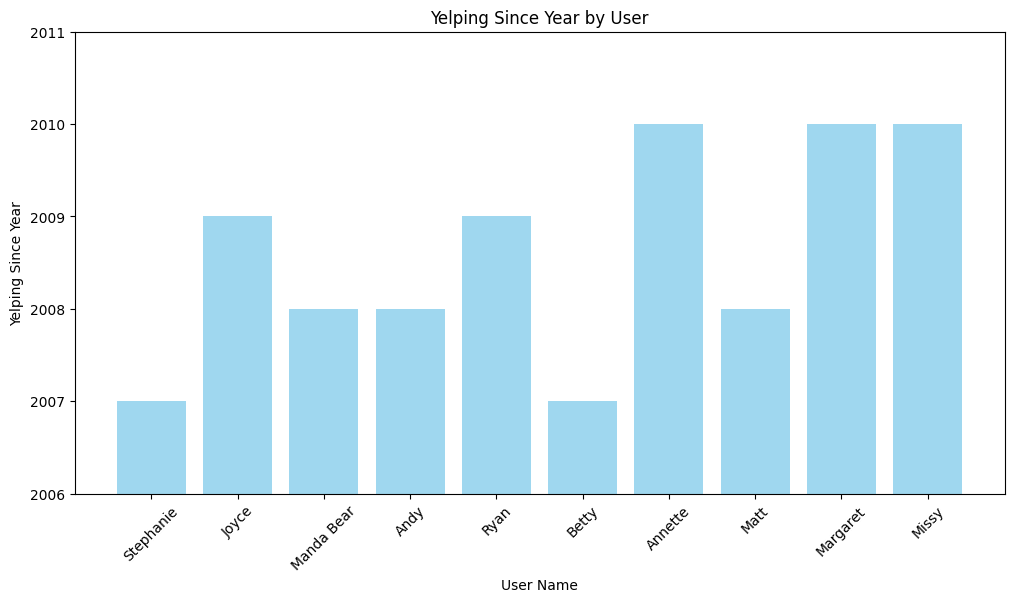

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "name": ["Stephanie", "Joyce", "Manda Bear", "Andy", "Ryan", "Betty", "Annette", "Matt", "Margaret", "Missy"],
    "yelping_since_year": [2007, 2009, 2008, 2008, 2009, 2007, 2010, 2008, 2010, 2010]
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

plt.bar(df["name"], df["yelping_since_year"], color="skyblue", alpha=0.8)

plt.xlabel("User Name")
plt.ylabel("Yelping Since Year")
plt.title("Yelping Since Year by User")
plt.ylim(2006, 2011) 

plt.xticks(rotation=45)

plt.show()


## Query 6
### Where do popular users come from?

Datasets used: user_df, review_df, business_df

In [18]:
final_user_df.createOrReplaceTempView("filtered_users")
final_review_df.createOrReplaceTempView("filtered_reviews")
mexican_restaurants.createOrReplaceTempView("mexican_restaurants")

popular_users_cities = spark.sql("""
SELECT 
    u.user_id AS user_id,
    u.name AS user_name,
    u.fans AS fan_count,
    m.city AS city_name
FROM 
    filtered_users u
JOIN 
    filtered_reviews r 
ON 
    u.user_id = r.user_id
JOIN 
    mexican_restaurants m 
ON 
    r.business_id = m.business_id
GROUP BY 
    u.user_id, u.name, u.fans, m.city
ORDER BY 
    fan_count DESC
LIMIT 10
""")

popular_users_cities.show(truncate=False)


+----------------------+----------+---------+---------+
|user_id               |user_name |fan_count|city_name|
+----------------------+----------+---------+---------+
|wEE-YMx5pmSuagLtNxMPKA|Stephanie |1761     |Tucson   |
|zFYs8gSUYDvXkb6O7YkRkw|Joyce     |1662     |Tucson   |
|JADdo9NEeO5Az9aOYbyvZA|Manda Bear|1648     |Tucson   |
|IDVFG1pNSHIHoVuoLuZpcQ|Andy      |1377     |Tucson   |
|nxWrhF_hyX0wwjrEkQX8uQ|Ryan      |1260     |Tucson   |
|mvK1pv-x0Z5rP4Hz9cWBWw|Betty     |1165     |Tucson   |
|jt49xjEjQisu6wTTGn6B3A|Annette   |1091     |Tucson   |
|f1MFQxTZAWJnRQdrouLg_A|Matt      |1082     |Tucson   |
|chhv5egoLSXHs4my1HCJeg|Margaret  |1054     |Tucson   |
|NrSURtBigpxbdfL4nGB-Jg|Missy     |1003     |Tucson   |
+----------------------+----------+---------+---------+



### Query 7
## Find the mexican restaurant customers who received most compliments?

Dataset used: user_df

In [19]:
user_with_comp= spark.sql("""
SELECT user_id, name, compliment_writer + compliment_photos + compliment_list AS total_compliments
FROM filtered_users
ORDER BY total_compliments DESC
LIMIT 10
""")

user_with_comp.show()

+--------------------+-------+-----------------+
|             user_id|   name|total_compliments|
+--------------------+-------+-----------------+
|0juzbrgcLHqobdK-O...| Daniel|            13568|
|zFYs8gSUYDvXkb6O7...|  Joyce|            12564|
|UXbCcmkYGl3DH_Py5...|   Toni|            11200|
|Hm0diOkWwpo9zotlJ...|    May|            11152|
|hWDybu_KvYLSdEFzG...|  Bruce|             8111|
|DK57YibC5ShBmqQl9...|  Karen|             8043|
|mvK1pv-x0Z5rP4Hz9...|  Betty|             5382|
|KFKrsDRkeo7KqQCm3...|   Shal|             3560|
|T7UOTXOsi6ZdJkzy8...|   Fred|             3549|
|A0j21z2Q1HGic7jW6...|Georgie|             3499|
+--------------------+-------+-----------------+



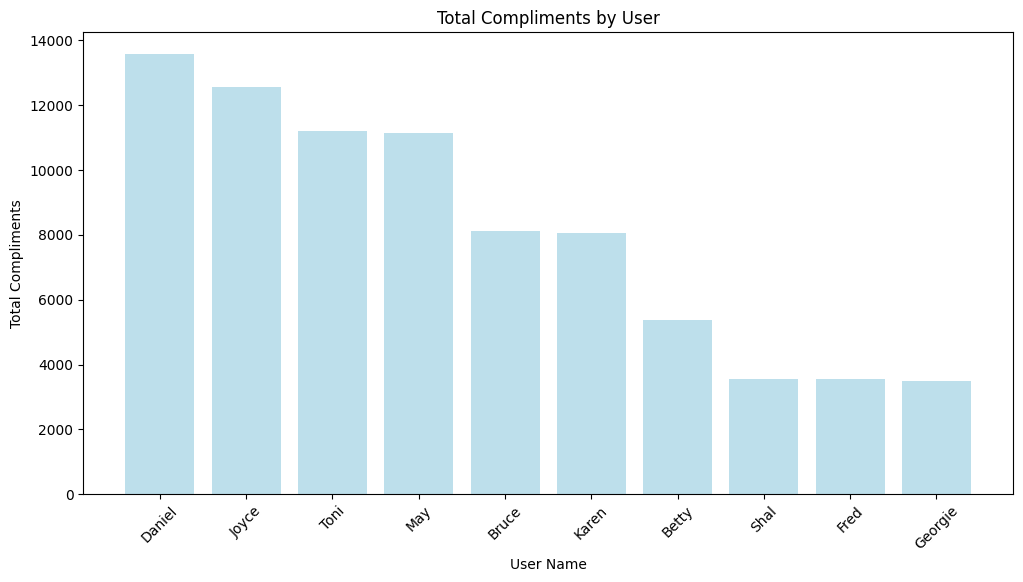

In [20]:
data = {
    "name": ["Daniel", "Joyce", "Toni", "May", "Bruce", "Karen", "Betty", "Shal", "Fred", "Georgie"],
    "total_compliments": [13568, 12564, 11200, 11152, 8111, 8043, 5382, 3560, 3549, 3499]
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

plt.bar(df["name"], df["total_compliments"], color="lightblue", alpha=0.8)

plt.xlabel("User Name")
plt.ylabel("Total Compliments")
plt.title("Total Compliments by User")

plt.xticks(rotation=45)

plt.show()

## Query 8
### List the tips, reviews received by the most Complimented Users

Datasets used: user_df, tips_df, review_df, mexican restaurants.

In [21]:
most_complimented_users_mexican = spark.sql("""
SELECT 
    u.user_id AS user_id,
    u.name AS user_name,
    (u.compliment_writer + u.compliment_photos + u.compliment_list) AS total_compliments,
    COUNT(r.review_id) AS total_reviews,
    COUNT(t.text) AS total_tips
FROM 
    filtered_users u
LEFT JOIN 
    filtered_reviews r 
ON 
    u.user_id = r.user_id
LEFT JOIN 
    filtered_tips t 
ON 
    u.user_id = t.user_id
JOIN 
    mexican_restaurants m 
ON 
    r.business_id = m.business_id OR t.business_id = m.business_id
GROUP BY 
    u.user_id, u.name, u.compliment_writer, u.compliment_photos, u.compliment_list
ORDER BY 
    total_compliments DESC, total_reviews DESC
LIMIT 10
""")

most_complimented_users_mexican.show(truncate=False)


+----------------------+---------+-----------------+-------------+----------+
|user_id               |user_name|total_compliments|total_reviews|total_tips|
+----------------------+---------+-----------------+-------------+----------+
|0juzbrgcLHqobdK-OZAyiw|Daniel   |13568            |1            |0         |
|zFYs8gSUYDvXkb6O7YkRkw|Joyce    |12564            |1            |0         |
|UXbCcmkYGl3DH_Py5UOtbQ|Toni     |11200            |5            |0         |
|Hm0diOkWwpo9zotlJlqMUQ|May      |11152            |1            |0         |
|hWDybu_KvYLSdEFzGrniTw|Bruce    |8111             |1            |0         |
|DK57YibC5ShBmqQl97CKog|Karen    |8043             |52           |52        |
|mvK1pv-x0Z5rP4Hz9cWBWw|Betty    |5382             |1            |0         |
|KFKrsDRkeo7KqQCm3IN5-g|Shal     |3560             |21           |21        |
|T7UOTXOsi6ZdJkzy8czTMw|Fred     |3549             |1            |0         |
|A0j21z2Q1HGic7jW6e9h7A|Georgie  |3499             |7           

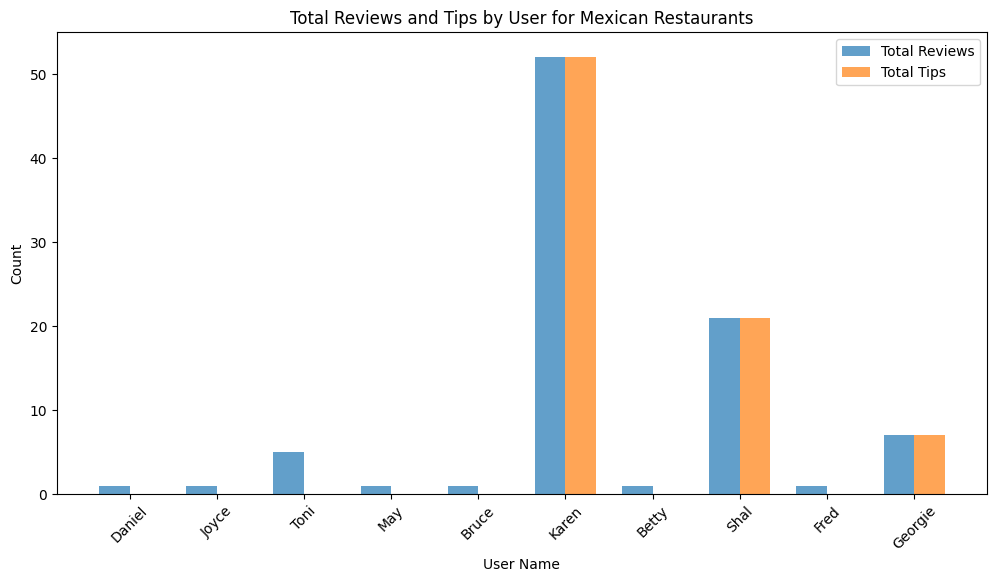

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
data = {
    "user_name": ["Daniel", "Joyce", "Toni", "May", "Bruce", "Karen", "Betty", "Shal", "Fred", "Georgie"],
    "total_reviews": [1, 1, 5, 1, 1, 52, 1, 21, 1, 7],
    "total_tips": [0, 0, 0, 0, 0, 52, 0, 21, 0, 7]
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
x = range(len(df["user_name"]))
width = 0.35 

plt.bar(x, df["total_reviews"], width=width, label="Total Reviews", alpha=0.7)
plt.bar([p + width for p in x], df["total_tips"], width=width, label="Total Tips", alpha=0.7)

plt.xticks([p + width / 2 for p in x], df["user_name"], rotation=45)

plt.xlabel("User Name")
plt.ylabel("Count")
plt.title("Total Reviews and Tips by User for Mexican Restaurants")
plt.ylim(0, 55)

plt.legend()

In the below code for the sentiment analysis , I used TeextBlob library.  It calculates sentiment which is a score ranging from -1 (negative) to +1 (positive) and 0 indicates neutral sentiment. 

I registered the function as Pyspark user defined function (udf) to be flexible within the pyspark enviornment

Then WithColumn method is used to apply this UDF to the text column of the final_review_df and creating a new column sentiment_score that stores the sentiment polarity for each review.

In [23]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity
sentiment_udf = udf(calculate_sentiment, FloatType())

final_review_df = final_review_df.withColumn("sentiment_score", sentiment_udf(final_review_df["text"]))


Here I created a new temporary view as final_review_df to avoid confusion with the previous temp view of review_df which is filtered_review_df

In [24]:
final_review_df.createOrReplaceTempView("filtered_reviews_sentiment")

## Query 9
### Calculate the average sentiment of the reviews written by the popular users

Datasets used : review_df , business_df, user_df

In [25]:
sentiment_by_popular_users_and_restaurants = spark.sql("""
SELECT 
    u.name AS user_name,
    u.fans AS fan_count,
    m.name AS restaurant_name,
    m.stars AS restaurant_stars,
    ROUND(AVG(r.sentiment_score), 2) AS avg_sentiment
FROM 
    filtered_users u
JOIN 
    filtered_reviews_sentiment r 
ON 
    u.user_id = r.user_id
JOIN 
    mexican_restaurants m
ON 
    r.business_id = m.business_id
WHERE 
    u.fans > 1000
GROUP BY 
    u.name, u.fans, m.name, m.stars
ORDER BY 
    fan_count DESC, avg_sentiment DESC
LIMIT 10
""")

sentiment_by_popular_users_and_restaurants.show(truncate=False)


+----------+---------+------------------------------+----------------+-------------+
|user_name |fan_count|restaurant_name               |restaurant_stars|avg_sentiment|
+----------+---------+------------------------------+----------------+-------------+
|Stephanie |1761     |BK Tacos                      |4.0             |0.1          |
|Joyce     |1662     |Rosa's Mexican Food Restaurant|3.5             |0.39         |
|Manda Bear|1648     |Gentle Ben’s Brewery          |3.5             |0.1          |
|Andy      |1377     |El Guero Canelo               |4.0             |0.28         |
|Ryan      |1260     |Taqueria Y Raspados Jason     |4.5             |0.24         |
|Ryan      |1260     |Street- Taco and Beer Co.     |4.5             |0.2          |
|Betty     |1165     |Tucson Tamale Company         |4.0             |0.2          |
|Annette   |1091     |The Quesadillas               |4.5             |0.3          |
|Matt      |1082     |Penca                         |3.5         

## Query 10
### Which mexican restaurant cities has the highest avg sentiment scores for reviews and how many popular users are in each city?

Datasets used: business_df, user_df, review_df

In [26]:
sentiment_by_popular_users_and_cities = spark.sql("""
SELECT 
    m.city AS city_name,
    COUNT(DISTINCT u.name) AS total_popular_users,
    COUNT(r.review_id) AS total_reviews,
    ROUND(AVG(r.sentiment_score), 2) AS avg_sentiment
FROM 
    filtered_users u
JOIN 
    filtered_reviews_sentiment r 
ON 
    u.user_id = r.user_id
JOIN 
    mexican_restaurants m
ON 
    r.business_id = m.business_id
WHERE 
    u.fans > 100 
GROUP BY 
    m.city
ORDER BY 
    avg_sentiment DESC, total_reviews DESC
LIMIT 10
""")

sentiment_by_popular_users_and_cities.show(truncate=False)


+----------+-------------------+-------------+-------------+
|city_name |total_popular_users|total_reviews|avg_sentiment|
+----------+-------------------+-------------+-------------+
|Catalina  |1                  |1            |0.31         |
|Tucson    |158                |485          |0.23         |
|Oro Valley|6                  |6            |0.2          |
|Vail      |1                  |1            |0.17         |
|Marana    |1                  |1            |-0.03        |
+----------+-------------------+-------------+-------------+



Below two code shells show the restaurants with positive sentiment scores and with negative sentiment scores.

In [27]:
from pyspark.sql.functions import col, avg, count, round as _round

high_sentiment_mexican_restaurants = (
    final_review_df.alias("r")
    .join(mexican_restaurants.alias("m"), col("r.business_id") == col("m.business_id"))
    .groupBy("m.name", "m.city")
    .agg(
        count("r.review_id").alias("total_reviews"),
        _round(avg("r.sentiment_score"), 2).alias("avg_sentiment")
    )
    .filter(col("avg_sentiment") > 0.4) 
    .orderBy(col("avg_sentiment").desc(), col("total_reviews").desc())  
    .limit(3)  
)
high_sentiment_mexican_restaurants.show(truncate=False)


+----------------------------------+------+-------------+-------------+
|name                              |city  |total_reviews|avg_sentiment|
+----------------------------------+------+-------------+-------------+
|Buendia Breakfast & Lunch Cafe    |Tucson|23           |0.49         |
|Tacos y Hotdogs El Giro           |Tucson|11           |0.43         |
|Cocteleria La Palma Mariscos Y Mas|Tucson|58           |0.42         |
+----------------------------------+------+-------------+-------------+



In [28]:
from pyspark.sql.functions import col, avg, count, round as _round

high_sentiment_mexican_restaurants = (
    final_review_df.alias("r")
    .join(mexican_restaurants.alias("m"), col("r.business_id") == col("m.business_id"))
    .groupBy("m.name", "m.city")
    .agg(
        count("r.review_id").alias("total_reviews"),
        _round(avg("r.sentiment_score"), 2).alias("avg_sentiment")
    )
    .filter(col("avg_sentiment") < 0 )  
    .orderBy(col("avg_sentiment").desc(), col("total_reviews").desc())  
    .limit(3)  
)

high_sentiment_mexican_restaurants.show(truncate=False)

+--------------+------+-------------+-------------+
|name          |city  |total_reviews|avg_sentiment|
+--------------+------+-------------+-------------+
|Carl's Jr.    |Tucson|9            |-0.01        |
|Totopos       |Tucson|12           |-0.02        |
|el Pollo Lucky|Tucson|10           |-0.02        |
+--------------+------+-------------+-------------+

